# Sign Language Recognition with MNIST Sign Language Dataset

In this notebook, a simple Convolutional Neural Network (CNN) is constructed and trained on MNIST Sign Language Dataset [1] to recognize sign language letters. The dataset includes 27455 and 7172 rows for training and testing respectively. Each row stores a vector of 784 pixels that represent 784 gray scale pixels of the immage in a flattened fashion.

[1] https://www.kaggle.com/datamunge/sign-language-mnist?select=sign_mnist_train.

### Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Reading the Data

In [2]:
train_df = pd.read_csv("sign_mnist_train.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
test_df = pd.read_csv("sign_mnist_test.csv")
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


### Preprocessing the Data

Labels in the dataset are not continous. There is a jump from 8 to 10. Tensorflow needs labels without jumps. In the below cell labels of images are reassigned in order to be compatible with a Sequential Tensorflow model.  

In [4]:
train_df.loc[train_df["label"] >= 10,["label"]] -= 1
test_df.loc[test_df["label"] >= 10,["label"]] -= 1

In the below cell, train and test data are shuffled simultaneously to avoid class imbalances in different regions of the training set.

In [5]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

### Class Distribution

Here we check the histogram to get an idea about the class distribution.

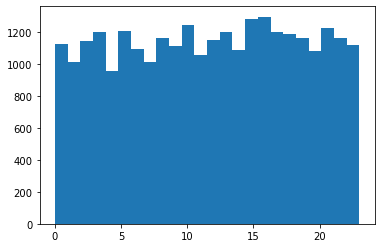

In [6]:
histo = plt.hist(train_df["label"],bins=24)
plt.show()

In [7]:
histo[0].mean(), histo[0].std(), histo[0].max(), histo[0].min()

(1143.9583333333333, 81.99516203546537, 1294.0, 957.0)

### Chi-Square Test to Check Uniformity of the Class Distribution

#### To see if the uniformity of the class distribution is *STATISTICALLY SIGNIFICANT* we apply a Chi-Square test on the data.

H0: The class distribution in the dataset is uniform. (i.e. uniformity is statistically significant.)

Ha: The class distribution in the dataset is not uniform. (i.e. uniformity is not statistically significant.)

In [8]:
from scipy.stats import chisquare, chi2

unique_labels, counts = np.unique(train_df["label"], return_counts = True)
expected_freq = train_df["label"].shape[0]/unique_labels.shape[0]

chi_0 = chisquare(counts,expected_freq)
chi_0025_n = chi2.ppf(1 - .05, df = train_df.shape[0] - 1)
print("Chi_0:", chi_0)
print("Chi_0025_n:", chi_0025_n) 

Chi_0: Power_divergenceResult(statistic=141.05142961209253, pvalue=5.915437888204953e-19)
Chi_0025_n: 27840.563279483347


Since chi_0 is smaller than chi_0025_n we failed to reject our null hypothesis. The class distribution in the dataset is uniform with *0.95* confidence.

### MinMax Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_df.iloc[:,1:])
x_train = x_train.reshape(train_df.shape[0],28,28,1)
y_train = train_df["label"].to_numpy()

In [10]:
x_test = scaler.fit_transform(test_df.iloc[:,1:])
x_test = x_test.reshape(test_df.shape[0],28,28,1)
y_test = test_df["label"].to_numpy()

### Model

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(24))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

### Training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
858/858 [==============================] - 19s 21ms/step - loss: 1.3790 - accuracy: 0.5733 - val_loss: 0.7797 - val_accuracy: 0.7337
Epoch 2/10
858/858 [==============================] - 19s 22ms/step - loss: 0.2851 - accuracy: 0.9092 - val_loss: 0.7030 - val_accuracy: 0.7931
Epoch 3/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0872 - accuracy: 0.9777 - val_loss: 0.6893 - val_accuracy: 0.8120
Epoch 4/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0358 - accuracy: 0.9921 - val_loss: 0.6311 - val_accuracy: 0.8572
Epoch 5/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0264 - accuracy: 0.9928 - val_loss: 0.6250 - val_accuracy: 0.8593
Epoch 6/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0105 - accuracy: 0.9979 - val_loss: 0.6197 - val_accuracy: 0.8696
Epoch 7/10
858/858 [==============================] - 17s 20ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.5955 - val_accuracy:

### Accuracy (Validation Accuracy) vs Epoch Plot

225/225 - 1s - loss: 0.8466 - accuracy: 0.8316


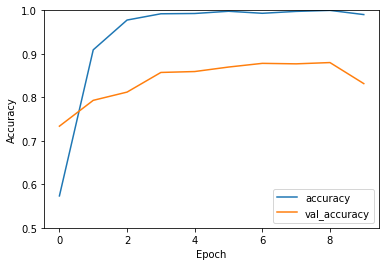

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

 Looks like we have reached a plateau. Lets go for another 10 epochs on training to see if that is the case.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0151 - accuracy: 0.9957 - val_loss: 0.5553 - val_accuracy: 0.8914
Epoch 2/10
858/858 [==============================] - 18s 21ms/step - loss: 7.5446e-04 - accuracy: 0.9999 - val_loss: 0.6119 - val_accuracy: 0.8915
Epoch 3/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.6065 - val_accuracy: 0.8776
Epoch 4/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.9709 - val_accuracy: 0.8210
Epoch 5/10
858/858 [==============================] - 18s 21ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.6118 - val_accuracy: 0.8836
Epoch 6/10
858/858 [==============================] - 18s 21ms/step - loss: 1.9325e-04 - accuracy: 1.0000 - val_loss: 0.6168 - val_accuracy: 0.8893
Epoch 7/10
858/858 [==============================] - 18s 21ms/step - loss: 1.0270e-04 - accuracy: 1.0000 - val_loss: 0.6604 - v

225/225 - 1s - loss: 0.6886 - accuracy: 0.8908


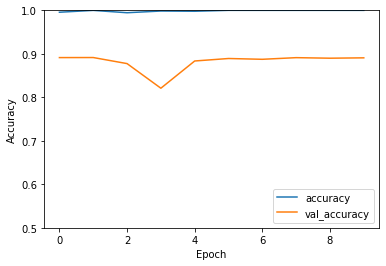

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

As we can see neither validation accuracy nor training accuracy is improving. This may indicate that we need a more complex model to further development. 

## A cell for demonstrating a prediction and the actual image using PIL for displaying the image.

--------------
The model predicted this instance as label 16
--------------
Where its label is 19


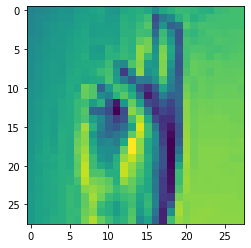

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
instance = 689

imshow(np.asarray(x_test[instance].reshape(28,28)))
print("--------------")
print("The model predicted this instance as label", model.predict(x_test[instance:instance+1])[0].argmax())
print("--------------")
print("Where its label is", y_test[instance])

## Confusion Matrix and Different Accuracy Parameters

In [17]:
from sklearn.metrics import classification_report
pred = [x.argmax() for x in model.predict(x_test)]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       331
           1       1.00      0.90      0.95       432
           2       0.93      1.00      0.97       310
           3       1.00      0.92      0.96       245
           4       0.94      0.99      0.96       498
           5       0.83      1.00      0.91       247
           6       0.82      0.69      0.75       348
           7       0.90      0.93      0.91       436
           8       0.93      0.99      0.96       288
           9       0.93      0.93      0.93       331
          10       0.84      0.99      0.91       209
          11       0.89      0.87      0.88       394
          12       0.88      0.77      0.82       291
          13       0.95      0.84      0.89       246
          14       0.92      0.89      0.90       347
          15       0.71      1.00      0.83       164
          16       0.75      0.42      0.54       144
          17       0.78    